https://www.kaggle.com/rohanrao/ashrae-half-and-half
half and half

In [3]:
import gc, os, random, pickle

import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

plt.style.use("seaborn")
sns.set(font_scale=1)

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

In [4]:
df_train = pd.read_csv('../data/train.csv')
building = pd.read_csv('../data/building_metadata.csv')

weather_train =pd.read_csv('../data/weather_train.csv')

In [5]:
le= LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)

In [6]:
# 内存压缩

def reduce_mem_usage(df):
    '''迭代所有列，减少内存使用'''
    start_mem = df.memory_usage().sum() / (1024**2)
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df_train = reduce_mem_usage(df_train)
building = reduce_mem_usage(building)
weather_train= reduce_mem_usage(weather_train)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 0.06 MB
Memory usage after optimization is: 0.02 MB
Decreased by 72.6%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


In [8]:
def prepare_data(X, building_data, weather_data, test=False):
    
    X = X.merge(building_data, on='building_id', how='left')
    X = X.merge(weather_data, on=['site_id', 'timestamp'], how='left')
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet= np.log1p(X.square_feet)
    if not test:
        X.sort_values('timestamp', inplace=True)
        X.reset_index(drop=True, inplace=True)
    gc.collect()
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed"]

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y
    
    

In [9]:
X_train, y_train = prepare_data(df_train,building, weather_train)
del df_train, weather_train
gc.collect()

97

## 分成两折交叉验证， half-and-half

按timestamp分成两部分

half1： 前50%作为训练集
half2： 后50% 作为训练集

In [12]:
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2) : ]
y_half_1= y_train[:int(X_train.shape[0] / 2)]
y_half_2= y_train[int(X_train.shape[0] / 2):]



In [13]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]
d_half_1 = lgb.Dataset(X_half_1,label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)
watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]


params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("构造模型1： first 50% train and second 50% valid")
modle_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, 
                         valid_sets=watchlist_1, verbose_eval=200, 
                         early_stopping_rounds=200)
print("构造模型2： second 50% train and first 50% valid")
modle_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, 
                         valid_sets=watchlist_2, verbose_eval=200, 
                         early_stopping_rounds=200)



构造模型1： first 50% train and second 50% valid


C:\Users\bai\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\bai\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.936309	valid_1's rmse: 1.34658
[400]	training's rmse: 0.881551	valid_1's rmse: 1.33794
[600]	training's rmse: 0.852859	valid_1's rmse: 1.33673
Early stopping, best iteration is:
[567]	training's rmse: 0.857856	valid_1's rmse: 1.33605
构造模型2： second 50% train and first 50% valid
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.922801	valid_1's rmse: 1.51106
[400]	training's rmse: 0.869536	valid_1's rmse: 1.50121
[600]	training's rmse: 0.845754	valid_1's rmse: 1.49977
[800]	training's rmse: 0.82958	valid_1's rmse: 1.49984
Early stopping, best iteration is:
[715]	training's rmse: 0.836806	valid_1's rmse: 1.49926


## 输出特征重要性

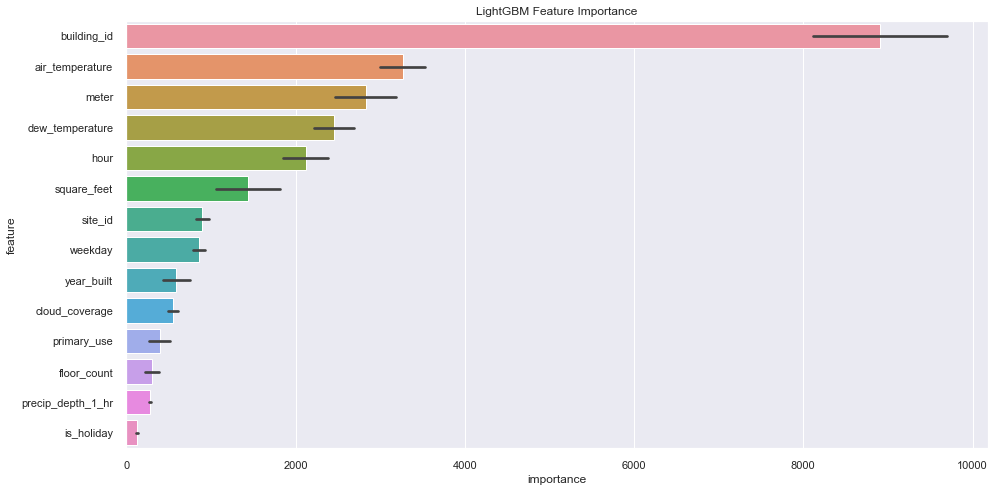

In [17]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = modle_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = modle_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

## 处理test数据

In [18]:
df_test = pd.read_csv("../data//test.csv")
weather_test = pd.read_csv("../data/weather_test.csv")

df_tes = reduce_mem_usage(df_test)
weather_test = reduce_mem_usage(weather_test)

X_test, row_ids = prepare_data(df_test, building, weather_test, test=True)


Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.25 MB
Decreased by 72.4%


In [20]:
pred = np.expm1(modle_half_1.predict(X_test, num_iteration=modle_half_1.best_iteration)) / 2

del modle_half_1
gc.collect()

pred += np.expm1(modle_half_2.predict(X_test, num_iteration=modle_half_2.best_iteration)) / 2
    
del modle_half_2
gc.collect()

19

In [22]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv("submission_half_and_half.csv", index=False)

In [ ]:
# 线上结果1.10